In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(r"../")
from data_loader import load_data, get_entire_data, get_features, split_train_valid_test_categorical
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cluster import KMeans

from xgboost import XGBRegressor

from datetime import datetime
import numpy as np

In [3]:
IS_CUSTOM = True
USE_VALID = False
DROPS = [
        "assessmentItemID", "testId", "Timestamp",'year', 'day', 'minute', 'second', 
        # 'userID',
        # 'KnowledgeTag',
        # 'userAnswerRate',
        # 'userSolvedLen',
        # 'testAnswerRate',
        # 'testSolvedLen', 
        # 'tagAnswerRate', 
        # 'tagSolvedLen',
        # 'itemAnswerRate', 
        # 'itemSolvedLen', 
        # 'month', 
        # 'hour',
        # 'first3', 
        # 'mid3', 
        # 'last3', 
        # 'timeConcentrationRate',
        # 'timeConcentrationCount', 
        # 'timeConcentrationLevel',
        # 'user_correct_answer', 
        # 'user_total_answer', 
        # 'user_acc',
        # 'monthAnswerRate', 
        # 'monthSolvedCount'
    ]

In [4]:
def clustering(
    items,
    n_clusters=27, 
    init='k-means++', 
    max_iter=300, 
    random_state=42
):
    """ Clustering data """
    kmeans = KMeans()
    kmeans.fit(items)
    return kmeans.labels_

def get_clu_tag_item(df):
    """clustering tag and item"""
    new_df = df.copy()
    new_df["clu_tag_item"]=clustering(new_df[["KnowledgeTag","first3","testAnswerRate"]])
    print(new_df["clu_tag_item"])
    return new_df
    
_train, _test = load_data(IS_CUSTOM=IS_CUSTOM)
entire_data = get_entire_data(_train, _test)
df = get_features(entire_data).drop(DROPS, axis=1)
train, valid, test = split_train_valid_test_categorical(df)
if not USE_VALID:
    train = pd.concat([train,valid])
    valid = valid.drop([val for val in valid.index], axis=0)

In [5]:
x_train = train.drop(["answerCode"], axis=1)
y_train = train["answerCode"]
x_valid = valid.drop(["answerCode"], axis=1)
y_valid = valid["answerCode"]

# XGB preprocessing

In [6]:
def xgb_preprocessing(data):
    for col in data.columns:
        data[col] = data[col].astype(float)
    return data


x_train = xgb_preprocessing(x_train)
x_valid = xgb_preprocessing(x_valid)
test = xgb_preprocessing(test)
test.columns

Index(['userID', 'answerCode', 'KnowledgeTag', 'userAnswerRate',
       'userSolvedLen', 'testAnswerRate', 'testSolvedLen', 'tagAnswerRate',
       'tagSolvedLen', 'itemAnswerRate', 'itemSolvedLen', 'month', 'hour',
       'first3', 'mid3', 'last3', 'timeConcentrationRate',
       'timeConcentrationCount', 'timeConcentrationLevel',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'monthAnswerRate', 'monthSolvedCount'],
      dtype='object')

# XGBRegressor

In [7]:
model = XGBRegressor(tree_method="gpu_hist", gpu_id=0)

if USE_VALID:
    model = XGBRegressor(tree_method="gpu_hist", gpu_id=0, early_stopping_rounds=100)

param_grid = {
    "booster": ["gbtree"],
    "colsample_bylevel": [0.9],
    "colsample_bytree": [0.8],
    "gamma": [3],
    "max_depth": [9],
    "min_child_weight": [3],
    "n_estimators": [500],
    "nthread": [4],
    "objective": ["binary:logistic"],
    "random_state": [42],
    "verbosity": [1],
}
cv = KFold(n_splits=6, random_state=42, shuffle=True)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=4,
    pre_dispatch=8,
    verbose=1,
)

In [8]:
if USE_VALID:
    gcv.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=True)
else:
    gcv.fit(x_train, y_train, verbose=True)

print("final params", gcv.best_params_)
print("best score", gcv.best_score_)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
final params {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 42, 'verbosity': 1}
best score 0.8211018377704354


In [17]:
# SAVE OUTPUT
model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(test.drop("answerCode", axis=1))

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"XGB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/XGBR_grid_kfold_custom_submission_2022-11-25_16:02:23.csv


In [10]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [11]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


accuracy_score: 0.7029569892473119
roc  auc_score: 0.7822395997161731


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

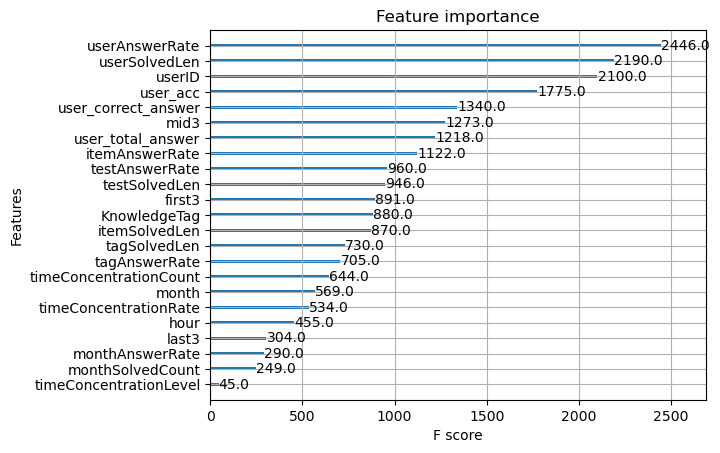

In [12]:
from xgboost import plot_importance
plot_importance(model)

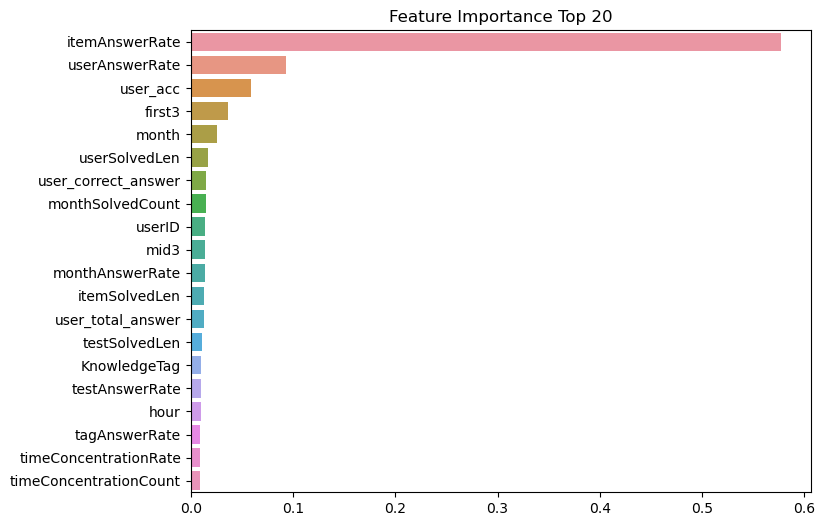

In [13]:

ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()